## PageRankとGoogle行列

最近PageRankとGoogle行列について調べる必要があったので、メモ代わりにまとめてみる。

教科書は以下の通りで、数式の表現などもこれに合わせています。

- [Google PageRankの数理 ―最強検索エンジンのランキング手法を求めて](https://www.amazon.co.jp/Google-PageRank%E3%81%AE%E6%95%B0%E7%90%86-%E2%80%95%E6%9C%80%E5%BC%B7%E6%A4%9C%E7%B4%A2%E3%82%A8%E3%83%B3%E3%82%B8%E3%83%B3%E3%81%AE%E3%83%A9%E3%83%B3%E3%82%AD%E3%83%B3%E3%82%B0%E6%89%8B%E6%B3%95%E3%82%92%E6%B1%82%E3%82%81%E3%81%A6%E2%80%95-Amy-N-Langville/dp/4320122399)

実はこれを購入したのは、2013年(8年前)で、それまでずっと本棚に眠っていました。今回良いチャンスを頂いたので、要点をまとめてみます。

また、以下のPDFも参考にさせていただきました。

- http://www.kentmiyajima.com/document/pagerank.pdf
qiskitを利用して、量子アルゴリズムについて自分なりに勉強していこうと思います。

### github
- jupyter notebook形式のファイルは[こちら](https://github.com/hiroshi0530/wa-src/blob/master/rec/pagerank/base_nb.ipynb)

### google colaboratory
- google colaboratory で実行する場合は[こちら](https://colab.research.google.com/github/hiroshi0530/wa-src/blob/master/rec/pagerank/base_nb.ipynb)

### 筆者の環境

In [108]:
!sw_vers

ProductName:	Mac OS X
ProductVersion:	10.14.6
BuildVersion:	18G103


In [109]:
!python -V

Python 3.8.5


基本的なライブラリをインポートしそのバージョンを確認しておきます。

In [110]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd
import pandas as pd
import networkx as nx

from IPython.display import SVG, display

print('matplotlib version :', matplotlib.__version__)
print('scipy version :', scipy.__version__)
print('numpy version :', np.__version__)
print('pandas version :', pd.__version__)
print('nx version :', nx.__version__)

matplotlib version : 3.3.2
scipy version : 1.5.2
numpy version : 1.19.2
pandas version : 1.1.3
nx version : 2.5


## PageRank

PageRankというのは、ラリー・ページとセルゲイ・ブリンというGoogleの創業者の二人が作り出したウェブページをランキングする手法です。ウェブサイトが持つリンクと被リンクから関係から、ウェブサイトの価値を評価していこうというのが基本的な考えです。良いウェブサイトにリンクされているサイトは、価値が高くなります。このあたりの説明は検索すれば出てくるので割愛します。

数式で表現すると、あるサイトのPageRankは以下の様になります。

$$
r\left(P_{i}\right)=\sum_{P_{j} \in B_{P_{i}}} \frac{r\left(P_{j}\right)}{\left|P_{j}\right|}
$$

図で表すととてもわかりやすいです。

![svg](base_nb_files_local/pagerank.svg)

サイトAが10点、サイトBが20点、サイトCが30点のPageRankを持っていて、サイトAからはリンクが二つ出ていて、サイトBからは一つ、サイトCからは3つ出ています。ここでサイトDのPageRankを計算することを考えます。サイトDは、サイトA、サイトB、サイトCからリンクをもらっています。サイトAはPageRank10点で、二つのサイトへリンクを張っているので、一つのリンク先へのPageRankの寄与度は$\displaystyle \frac{10}{2}=5$になります。同様に、サイトBからは、$\displaystyle \frac{20}{1}=20$で、サイトCからは、$\displaystyle \frac{30}{3}=10$となり、合計して35点になります。

<br>

ここで問題なのが、上記ではサイトAは10点となっていますが、そもそもこれ自体をどう決めるのか？という事が問題になってきます。

そこで登場するのが、ランダムサーファーモデルになります。ランダムサーファーモデルは、サイトのハイパーリンクをランダムにたどっていき、それを無限回繰り返したときに、閲覧した割合順にサイトの順位を決めていきます。根本となる理論はマルコフ連鎖であり、サーファーは確率行列に従って、次の状態に遷移します。その遷移確率は、直前の状態だけに依存するというのが、マルコフ連鎖になります。

次の状態が、現在の状態にだけ依存するというのをマルコフ決定過程とも言い、一般的に以下の様な数式で表現できます。

$$
P\left(X_{t+1}=S_{j} \mid X_{t}=S_{i_{t}}, X_{t-1}=S_{i_{t-1}}, \ldots, X_{0}=S_{i_{0}}\right)=P\left(X_{t+1}=S_{j} \mid X_{t}=S_{i_{t}}\right)
$$

また、遷移確率行列は$i$から$j$に遷移する確率を$S_{ij}$で表し、

$$
\mathbf{S} = \left(\begin{array}{cccccc}
0 & 1 / 2 & 1 / 2 & 0 & 0 & 0 \\
1/6 & 1/6 & 1/6 & 1/6 & 1/6 & 1/6 \\
1 / 3 & 1 / 3 & 0 & 0 & 1 / 3 & 0 \\
0 & 0 & 0 & 0 & 1 / 2 & 1 / 2 \\
0 & 0 & 0 & 1 / 2 & 0 & 1 / 2 \\
0 & 0 & 0 & 1 & 0 & 0
\end{array}\right)
$$

のように表現できます。各行の和は必ず1になります。

ある時間$k$における状態ベクトルを$\pi$とすると、$k+1$の状態は

$$
\boldsymbol{\pi}^{(k+1)T}=\boldsymbol{\pi}^{(k)T} \mathbf{S}
$$

になります。$T$は転置行列を表します。$\pi$は各成分の状態になる確率を表します。つまり、上記の計算を無限回繰り返し、もし、$\pi$がある一つのベクトルに収束すると、そのベクトルの和が1になるように正規化されたベクトル各成分がPageRankに相当します。そして、$H$がGoogle行列と呼ばれる以下の様な確率的で既約行列

$$
\begin{aligned}
\mathbf{G} &=\alpha \mathbf{S}+(1-\alpha) \frac{\mathbf{E}}{n} \\
&=\alpha \mathbf{S}+(1-\alpha) 1 / n \mathbf{e e}^{T} \\
&=\alpha\left(\mathbf{H}+1 / n \mathbf{a e}^{T}\right)+(1-\alpha) 1 / n \mathbf{e e}^{T} \\
&=\alpha \mathbf{H}+(\alpha \mathbf{a}+(1-\alpha) \mathbf{e}) 1 / n \mathbf{e}^{T}
\end{aligned}
$$

で表現できる場合、あるベクトルに収束することはペロン−フロベニウスの定理により証明されています。$\mathbf{E}$は、すべての成分が1の行列であり、$\alpha$はリンクがなくても、あるサイトからあるサイトへランダムにジャンプする割合になります。

$\pi$があるベクトルに収束する時、

$$
\boldsymbol{\pi}^{T}=\boldsymbol{\pi}^{T}(\alpha \mathbf{S}+(1-\alpha) \mathbf{E})
$$

という関係になり、これはGoogle行列の固有値1の固有ベクトルに相当します。結局は、PageRankはGoogle行列の固有値1の固有ベクトルを求める事に帰着されます。そして、Google行列の場合、そのような固有ベクトルが存在することは証明されています。

## べき乗法
べき乗法は絶対値最大の固有値を求めるアルゴリズムで、最大の固有値とその次の大きさを持つ固有値が同じ程度の大きさを持つ場合、収束性が悪くなります。ただ、教科書によると、一般的なGoogle行列では収束性は悪くないようです。[wiki](https://ja.wikipedia.org/wiki/%E3%81%B9%E3%81%8D%E4%B9%97%E6%B3%95)を参照してください。

具体的にはGoogle行列との積を

$$
\boldsymbol{\pi}^{(k)T}= \boldsymbol{\pi}^{(k-1)T} \mathbf{G}
$$

のように繰り返し計算することで、$\mathbf{\pi}$がGoogle行列の最大の固有値に属する固有ベクトルに収束していく事を利用します。
$\mathbf{\pi}$の初期値はラリーページの論文には、

$$
\displaystyle \boldsymbol{\pi}^{(0) T}=\frac{1}{n} \mathbf{e}^{T}
$$

から始めるように書かれています。Google行列は確率行列なので、最大の固有値は必ず1になります。

## 実際の計算

理論だけではなく、実際にPageRankを計算してみます。まず、リンク、被リンクの関係は有向グラフで表現されるので、以下の様な簡単なネットワーク構造を考えます。

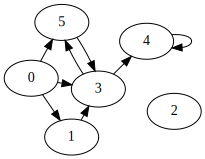

In [107]:
G = nx.DiGraph()

G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([(1, 3), (3, 5), (3, 4), (0, 3), (5, 3), (4, 4), (0, 1), (0, 5)])

svg = SVG(nx.nx_agraph.to_agraph(G).draw(prog='fdp', format='svg'))
display(svg)

何となく、ノード3が多くのサイトにリンクされており、ノード4がそのノード3にリンクされているため、この二つのランクが高くなりそうな感じがします。ノード2はどのサイトともリンク関係にないため、ランダムジャンプの重み$\alpha$の影響を強く受けそうです。

## 隣接行列、確率行列、Google行列

隣接行列$P_{ij}$は以下の通りになります。ノード$i$からノード$j$にエッジがあれば1をなければ0の成分を持つ行列になります。

$$
\mathbf{P} = \left(\begin{array}{cccccc}
0 & 1 & 0 & 1 & 0 & 1 \\
0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 1 \\
0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 & 0 & 0
\end{array}\right)
$$

これをすべての行の和が1になるように、確率行列$H_{ij}$を考えます。

$$
\mathbf{H} = \left(\begin{array}{cccccc}
0 & 1/3 & 0 & 1/3 & 0 & 1/3 \\
0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 / 2 & 1 / 2 \\
0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 & 0 & 0
\end{array}\right)
$$

ただし、これだと第2行の成分がすべて0であり、べき乗法による収束性が悪くなります。よって、すべての成分が0の行には、$\displaystyle \frac{1}{n}$の成分を持つように修正を加えます。

$$
\mathbf{S} = \mathbf{H} + \frac{\mathbf{a}\mathbf{e^T}}{n} = \left(\begin{array}{cccccc}
0 & 1/3 & 0 & 1/3 & 0 & 1/3 \\
0 & 0 & 0 & 1 & 0 & 0 \\
1/6 & 1/6 & 1/6 & 1/6 & 1/6 & 1/6 \\
0 & 0 & 0 & 0 & 1 / 2 & 1 / 2 \\
0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 & 0 & 0
\end{array}\right)
$$

$\displaystyle \mathbf{a}$は$i$行の要素がすべて0であれば1、そうでなければ0の成分を持つベクトルになります。

という形で、


$$
\mathbf{G}=\alpha \mathbf{S}+(1-\alpha) \mathbf{e e}^{T} / n 
$$

このGが具体的なGoogle行列です。

次に、$\alpha = 0.7$として、実際にGoogle行列の固有ベクトルを求め、PageRankを計算してみます。

In [111]:
# Sの計算
S = np.array([
  [0, 1/3, 0, 1/3, 0, 1/3],
  [0, 0, 0, 1, 0, 0],
  [1/6, 1/6, 1/6, 1/6, 1/6, 1/6],
  [0, 0, 0, 0, 1/2, 1/2],
  [0, 0, 0, 0, 1, 0],
  [0, 0, 0, 1, 0, 0],
]
)
S

array([[0.        , 0.33333333, 0.        , 0.33333333, 0.        ,
        0.33333333],
       [0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        ],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.        , 0.        , 0.        , 0.        , 0.5       ,
        0.5       ],
       [0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        ]])

In [112]:
alpha = 0.7
G = alpha * S + (1 - alpha) * np.ones((6,6)) / 6
G

array([[0.05      , 0.28333333, 0.05      , 0.28333333, 0.05      ,
        0.28333333],
       [0.05      , 0.05      , 0.05      , 0.75      , 0.05      ,
        0.05      ],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.05      , 0.05      , 0.05      , 0.05      , 0.4       ,
        0.4       ],
       [0.05      , 0.05      , 0.05      , 0.05      , 0.75      ,
        0.05      ],
       [0.05      , 0.05      , 0.05      , 0.75      , 0.05      ,
        0.05      ]])

このGoogle行列を使って、固有値1の固有ベクトルを計算します。

## べき乗法による固有ベクトルの計算

通常、Google行列は巨大なサイズになるため、解析的に求める事は出来ません。よってべき乗法を利用します。

In [113]:
piT = np.array([1 for i in range(6)]) / 6
piT

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])

In [119]:
# とりあえず、5回ほど回してみます
for i in range(5):
  piT = np.dot(piT, G)

In [120]:
piT

array([0.05660377, 0.06981132, 0.05660377, 0.22191693, 0.44758184,
       0.14748236])

In [121]:
# 次に10回してみます
for i in range(10):
  piT = np.dot(piT, G)

In [122]:
piT

array([0.05660377, 0.06981132, 0.05660377, 0.22191678, 0.44758216,
       0.14748219])

値はほとんど変化なく、この程度であれば、5回で十分収束していることが分かります。

## numpyによる固有値1の固有ベクトルの計算

べき乗法の結果を確かめるために、numpyで固有ベクトルを計算してみます。

In [116]:
ret = np.linalg.eig(G.T)
ret

(array([ 1.00000000e+00+0.00000000e+00j, -4.94974747e-01+0.00000000e+00j,
         4.94974747e-01+0.00000000e+00j, -2.92237077e-16+8.50412879e-09j,
        -2.92237077e-16-8.50412879e-09j,  1.16666667e-01+0.00000000e+00j]),
 array([[ 1.06476080e-01+0.00000000e+00j,  5.11651005e-17+0.00000000e+00j,
          5.09626608e-17+0.00000000e+00j,  3.17996523e-16-2.57714020e-08j,
          3.17996523e-16+2.57714020e-08j, -1.74821640e-01+0.00000000e+00j],
        [ 1.31320499e-01+0.00000000e+00j,  3.46882037e-18+0.00000000e+00j,
         -3.72987590e-17+0.00000000e+00j, -7.07106781e-01+0.00000000e+00j,
         -7.07106781e-01-0.00000000e+00j, -5.24464919e-01+0.00000000e+00j],
        [ 1.06476080e-01+0.00000000e+00j, -9.53925603e-17+0.00000000e+00j,
          6.92427457e-18+0.00000000e+00j,  1.10198775e-15+7.88171169e-23j,
          1.10198775e-15-7.88171169e-23j, -1.74821640e-01+0.00000000e+00j],
        [ 4.17442646e-01+0.00000000e+00j,  7.94104488e-01+0.00000000e+00j,
          4.75963149e-0

retの第一成分が固有値、第二成分が固有値に対応する固有ベクトルになります。固有値1が第一列なので、以下の様に固有値1の固有ベクトルを正規化して求める事出来ます。

In [117]:
pr = ret[1][:, 0] / np.sum(ret[1][:, 0])
np.abs(pr)

array([0.05660377, 0.06981132, 0.05660377, 0.22191678, 0.44758216,
       0.14748219])

べき乗法の結果とほとんど一致する事が分かります。

結果を少し解析すると、ノード4が最もPageRankが高く、次にノード3になっています。これは当初の予想通りです。ノード4がノード3の一つのノードからしかリンクをもらっていませんが、ノード3が三つのノードからリンクを得ており、そこからただ一つのリンクを得ているので、高いPageRankを得ている物と思われます。

## まとめ

Googleも1台のLinuxサーバーとpythonで作られたクローラー、PageRankからすべてが始まったといわれますが、創業者二人には尊敬の念しか出来てきません。おそらくPageRankの理論自体はそれほど難しい物ではないと思いますが、これを実際にサーバーに実装し、クローラーなどを含むサーバー群のシステム設計を行い、時価総額100兆円以上の企業を作りあげたその技術者、経営者としての手腕にただただ感動するばかりです。

## 参考文献

### 1998年に発表されたPageRankについての原著

- [1] S. Brin and L. Page. The anatomy of a large-scale hypertextual Web search engine. Computer Networks and ISDN Systems, Vol. 30, No. 1-7, pp. 107–117, 1998.
- [2] L. Page, S. Brin, R. Motwani, and T. Winograd. The pagerank citation ranking


<!--
### マルコフ行列のべき乗の収束条件


### 既約行列、可約行列、強連結行列

$A=\left(a_{i j}\right)$ を详数を成分とする $n \times n$ 行列 とする。頂点集合を $V=\{1,2, \ldots, n\}$ とし、矢集合を $E=\left\\{(i, j) \mid a_{j i} \neq 0\right\\}$ として定 まる有向グラフを $A$ の定めるグラフという。 $E$ の要素を矢 (arrow) という。頂点 $i$ か ら $i$ への矢も考える。矢を向きに沿っていくつかつないだものを道 (path) という。頂

$$
\mathbf{Q}^{T} \mathbf{B Q}=\left(\begin{array}{cc}
\mathbf{X} & \mathbf{Y} \\
\mathbf{0} & \mathbf{Z}
\end{array}\right)
$$


行列$\mathbf{L}^{T} \mathbf{L}$と$\mathbf{L L}^{T}$は対称半正定値行列となる。行列$\mathbf{L}^{T} \mathbf{L}$は権威行列、$\mathbf{L} \mathbf{L}^{T}$はハブ行列である。

既約で非負行列は、ペロン-フロベニウスの定理から唯一の正規化された固有ベクトルを持つ。その固有ベクトルがそれぞれのサイトのAuthority値とハブ値である。

HITSアルゴリズムが一意でない解に収束するのは、$\mathbf{L}^{T} \mathbf{L}$が可約行列だから。

Google行列は可約行列にするため、原子性行列にするために、ジャンプする確率を入れ込んだ。

$$
\begin{aligned}
&\mathbf{x}^{(k)}=\mathbf{L}^{T} \mathbf{L} \mathbf{x}^{(k-1)} \\
&\mathbf{y}^{(k)}=\mathbf{L} \mathbf{L}^{T} \mathbf{y}^{(k-1)}
\end{aligned}
$$

権威行列やハブ行列にもGoogle行列と同様に、$\displaystyle \xi \mathbf{L}^{T} \mathbf{L} + \frac{(1-\xi)}{n}\mathbf{e e}^{T}$とすることで、既約性を担保させることが可能。


べき乗法。

$$
\mathbf{x}^{(k)}=\mathbf{B} \mathbf{x}^{(k-1)}, \quad \mathbf{x}^{(k)} \longleftarrow-\frac{\mathbf{x}^{(k)}}{m\left(\mathbf{x}^{(k)}\right)}
$$
-->